In [1]:
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_union
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

C:\Users\Nanu\Anaconda3-1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nanu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nanu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nanu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
stop_words = set(stopwords.words('english'))
test_labels = pd.read_csv("test_labels.csv")
lemmatizer= WordNetLemmatizer()
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')


# Experimenting with two types of ngrams, one being a 1, 1 and another being 1, 4
wordVectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    max_features=30000)

charVectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 4),
    max_features=30000)

multiVectorizer = make_union(wordVectorizer, charVectorizer)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


C:\Users\Nanu\Anaconda3-1\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


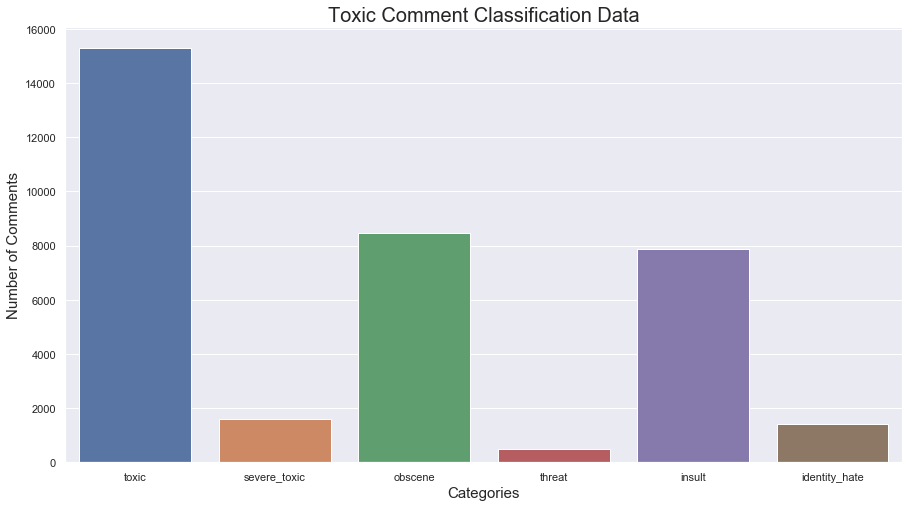

In [6]:
%matplotlib inline
categories = list(train.columns.values)[2:]
barPlotData = {}

for category in categories: 
    barPlotData[category] = train[train[category]==1].count()
    
barPlotDF = pd.DataFrame(data=barPlotData)
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(data=barPlotDF)
ax.axes.set_title("Toxic Comment Classification Data",fontsize= 20)
ax.set_xlabel("Categories",fontsize=15)
ax.set_ylabel("Number of Comments",fontsize=15)
ax.tick_params(labelsize=11)


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
id              153164 non-null object
comment_text    153164 non-null object
dtypes: object(2)
memory usage: 2.3+ MB


In [8]:
def isNonToxic(row): 
    if (row['threat'] or row['toxic'] or row['severe_toxic'] or row['obscene'] or row['insult'] or row['identity_hate']):
        return 0
    else: 
        return 1
    
def removeEverythingExceptWords(comment): 
    return re.sub('\W+',' ', comment)

def tokenizeAndLemmatize(comment):
    tokens = word_tokenize(comment)
    return [ lemmatizer.lemmatize(w) for w in tokens ]

def removeStopWords(comment_tokens):
    # Method to remove stop words from the comment 
    # Input argument: The comment_tokens after tokenizing the comment
    return ' '.join([w for w in comment_tokens if not w in stop_words])  

In [9]:
def compute_confusion_matrix(label, prediction):
    true_positives = 0.0
    false_positives = 0.0
    true_negatives = 0.0
    false_negatives = 0.0
    
    for i in range(len(label)):
        if ((label[i] == 0.0) and (prediction[i] == 0.0)):
            true_positives += 1.0
        elif ((label[i] == 1.0) and (prediction[i] == 1.0)): 
            true_negatives += 1.0
        elif ((label[i] == 0.0) and (prediction[i] == 1.0)):
            false_negatives += 1.0
        elif ((label[i] == 1.0) and (prediction[i] == 0.0)):
            false_positives += 1.0
    
    return (true_positives, true_negatives, false_positives, false_negatives)

def compute_evaluation_metrics(label, prediction):
    (true_positives, true_negatives, false_positives, false_negatives) = compute_confusion_matrix(label, prediction)
    accuracy = accuracy_score(label, prediction)
    precision = precision_score(label, prediction, average='micro')
    recall = recall_score(label, prediction, average='micro')
    f1score = f1_score(label, prediction, average='micro')
    return (accuracy, precision, recall, f1score)

In [10]:
trainingData = train
trainingData['nonToxic'] = trainingData.apply(lambda row: isNonToxic(row), axis = 1)
trainingData['parsedComments'] = trainingData.apply(lambda row: removeEverythingExceptWords(row['comment_text']), axis = 1)
trainingData['tokenizedComments'] = trainingData.apply(lambda row: tokenizeAndLemmatize(row['parsedComments']), axis = 1)
trainingData['noStopWordComments'] = trainingData.apply(lambda row: removeStopWords(row['tokenizedComments']), axis = 1)

In [11]:
trainingData[trainingData['nonToxic'] == 0].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,nonToxic,parsedComments,tokenizedComments,noStopWordComments
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,"[COCKSUCKER, BEFORE, YOU, PISS, AROUND, ON, MY...",COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,0,Hey what is it talk What is it an exclusive gr...,"[Hey, what, is, it, talk, What, is, it, an, ex...",Hey talk What exclusive group WP TALIBANS good...
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,0,Bye Don t look come or think of comming back T...,"[Bye, Don, t, look, come, or, think, of, commi...",Bye Don look come think comming back Tosser
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,0,You are gay or antisemmitian Archangel WHite T...,"[You, are, gay, or, antisemmitian, Archangel, ...",You gay antisemmitian Archangel WHite Tiger Me...
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,0,FUCK YOUR FILTHY MOTHER IN THE ASS DRY,"[FUCK, YOUR, FILTHY, MOTHER, IN, THE, ASS, DRY]",FUCK YOUR FILTHY MOTHER IN THE ASS DRY


In [12]:
trainTotal, testTotal = train_test_split(trainingData, random_state=42, test_size=0.30)

Now we extract the noStopWordComments from the data frames to perform feature engineering

In [13]:
vectorizer.fit(trainTotal['noStopWordComments'] )
vectorizer.fit(testTotal['noStopWordComments'])
trainX_tfidf = vectorizer.transform((trainTotal['noStopWordComments'])) 
testX_tfidf = vectorizer.transform((testTotal['noStopWordComments']))

multiVectorizer.fit(trainTotal['noStopWordComments'])
multiVectorizer.fit(testTotal['noStopWordComments'])

trainX_multi_tfidf = multiVectorizer.transform((trainTotal['noStopWordComments'])) 
testX_multi_tfidf = multiVectorizer.transform((testTotal['noStopWordComments']))

In [14]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier with one vectorizer. 
logisticRegressionPipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='lbfgs'), n_jobs=-1)),
            ])

for category in categories:
    print('**Learning on {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    logisticRegressionPipeline.fit(trainX_tfidf, trainTotal[category])
    
    # calculating test accuracy
    prediction = logisticRegressionPipeline.predict(testX_tfidf)
    (accuracy, precision, recall, f1score) = compute_evaluation_metrics((testTotal[category]).values, prediction)
    print('Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
    print("\n")
    

**Learning on toxic comments...**
Test accuracy is 0.9345964237967914%, precision is 0.9345964237967914, recall is 0.9345964237967914, and f1 score is 0.9345964237967914


**Learning on severe_toxic comments...**
Test accuracy is 0.9899732620320856%, precision is 0.9899732620320856, recall is 0.9899732620320856, and f1 score is 0.9899732620320856


**Learning on obscene comments...**
Test accuracy is 0.9625459558823529%, precision is 0.9625459558823529, recall is 0.9625459558823529, and f1 score is 0.9625459558823529


**Learning on threat comments...**
Test accuracy is 0.9971590909090909%, precision is 0.9971590909090909, recall is 0.9971590909090909, and f1 score is 0.9971590909090909


**Learning on insult comments...**
Test accuracy is 0.9587232620320856%, precision is 0.9587232620320856, recall is 0.9587232620320856, and f1 score is 0.9587232620320856


**Learning on identity_hate comments...**
Test accuracy is 0.9911639371657754%, precision is 0.9911639371657754, recall is 0.9911

In [15]:
# WARNING: DO NOT RUN

# Using pipeline for applying logistic regression and one vs rest classifier with multi vectorizer. 
logisticRegressionPipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='lbfgs'), n_jobs=-1)),
            ])

for category in categories:
    print('**Learning on {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    logisticRegressionPipeline.fit(trainX_multi_tfidf, trainTotal[category])
    
    # calculating test accuracy
    prediction = logisticRegressionPipeline.predict(testX_multi_tfidf)
    (accuracy, precision, recall, f1score) = compute_evaluation_metrics((testTotal[category]).values, prediction)
    print('Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
    print("\n")

**Learning on toxic comments...**
Test accuracy is 0.9616268382352942%, precision is 0.9616268382352942, recall is 0.9616268382352942, and f1 score is 0.961626838235294


**Learning on severe_toxic comments...**
Test accuracy is 0.990704378342246%, precision is 0.990704378342246, recall is 0.990704378342246, and f1 score is 0.990704378342246


**Learning on obscene comments...**
Test accuracy is 0.9792780748663101%, precision is 0.9792780748663101, recall is 0.9792780748663101, and f1 score is 0.9792780748663101


**Learning on threat comments...**
Test accuracy is 0.9974933155080213%, precision is 0.9974933155080213, recall is 0.9974933155080213, and f1 score is 0.9974933155080213


**Learning on insult comments...**
Test accuracy is 0.9719878008021391%, precision is 0.9719878008021391, recall is 0.9719878008021391, and f1 score is 0.9719878008021391


**Learning on identity_hate comments...**
Test accuracy is 0.9923128342245989%, precision is 0.9923128342245989, recall is 0.992312834

In [16]:
%%time 

supportVectorMachinePipeline = Pipeline([
        ('svm', OneVsRestClassifier(LinearSVC(random_state=0), n_jobs=-1)),
    ])

for category in categories:
    print('**Learning on {} comments...**'.format(category))
    
    # Training SVM on train data
    supportVectorMachinePipeline.fit(trainX_tfidf, trainTotal[category])
    
    # calculating test accuracy
    prediction = supportVectorMachinePipeline.predict(testX_tfidf)
    (accuracy, precision, recall, f1score) = compute_evaluation_metrics((testTotal[category]).values, prediction)
    print('Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
    print("\n")


**Learning on toxic comments...**
Test accuracy is 0.9477565173796791%, precision is 0.9477565173796791, recall is 0.9477565173796791, and f1 score is 0.9477565173796791


**Learning on severe_toxic comments...**
Test accuracy is 0.9901612633689839%, precision is 0.9901612633689839, recall is 0.9901612633689839, and f1 score is 0.9901612633689839


**Learning on obscene comments...**
Test accuracy is 0.9707344585561497%, precision is 0.9707344585561497, recall is 0.9707344585561497, and f1 score is 0.9707344585561497


**Learning on threat comments...**
Test accuracy is 0.9972635360962567%, precision is 0.9972635360962567, recall is 0.9972635360962567, and f1 score is 0.9972635360962567


**Learning on insult comments...**
Test accuracy is 0.9625877339572193%, precision is 0.9625877339572193, recall is 0.9625877339572193, and f1 score is 0.9625877339572193


**Learning on identity_hate comments...**
Test accuracy is 0.9912892713903744%, precision is 0.9912892713903744, recall is 0.9912

Let's also try ensembling the models to get a clearer view on the performance.

In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=2)

for category in categories:
    print('**Learning on {} comments...**'.format(category))
    
    # Training SVM on train data
    clf.fit(trainX_tfidf, trainTotal[category])
    
    # calculating test accuracy
    prediction = clf.predict(testX_tfidf)
    (accuracy, precision, recall, f1score) = compute_evaluation_metrics((testTotal[category]).values, prediction)
    print('Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
    print("\n")


C:\Users\Nanu\Anaconda3-1\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**Learning on toxic comments...**
Test accuracy is 0.9243816844919787%, precision is 0.9243816844919787, recall is 0.9243816844919787, and f1 score is 0.9243816844919787


**Learning on severe_toxic comments...**
Test accuracy is 0.9892003676470589%, precision is 0.9892003676470589, recall is 0.9892003676470589, and f1 score is 0.9892003676470589


**Learning on obscene comments...**
Test accuracy is 0.9567805815508021%, precision is 0.9567805815508021, recall is 0.9567805815508021, and f1 score is 0.9567805815508021


**Learning on threat comments...**
Test accuracy is 0.9971173128342246%, precision is 0.9971173128342246, recall is 0.9971173128342246, and f1 score is 0.9971173128342246


**Learning on insult comments...**
Test accuracy is 0.9569268048128342%, precision is 0.9569268048128342, recall is 0.9569268048128342, and f1 score is 0.9569268048128342


**Learning on identity_hate comments...**
Test accuracy is 0.9909132687165776%, precision is 0.9909132687165776, recall is 0.9909

In [18]:
%%time 

naiveBayesPipeline = Pipeline([
        ('nb', OneVsRestClassifier(MultinomialNB(), n_jobs=-1)),
    ])

for category in categories:
    print('**Learning on {} comments...**'.format(category))
    
    # Training SVM on train data
    naiveBayesPipeline.fit(trainX_tfidf, trainTotal[category])
    
    # calculating test accuracy
    prediction = naiveBayesPipeline.predict(testX_tfidf)
    (accuracy, precision, recall, f1score) = compute_evaluation_metrics((testTotal[category]).values, prediction)
    print('Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
    print("\n")

**Learning on toxic comments...**
Test accuracy is 0.908944685828877%, precision is 0.908944685828877, recall is 0.908944685828877, and f1 score is 0.908944685828877


**Learning on severe_toxic comments...**
Test accuracy is 0.9898479278074866%, precision is 0.9898479278074866, recall is 0.9898479278074866, and f1 score is 0.9898479278074866


**Learning on obscene comments...**
Test accuracy is 0.9477774064171123%, precision is 0.9477774064171123, recall is 0.9477774064171123, and f1 score is 0.9477774064171123


**Learning on threat comments...**
Test accuracy is 0.9971590909090909%, precision is 0.9971590909090909, recall is 0.9971590909090909, and f1 score is 0.9971590909090909


**Learning on insult comments...**
Test accuracy is 0.9503885360962567%, precision is 0.9503885360962567, recall is 0.9503885360962567, and f1 score is 0.9503885360962567


**Learning on identity_hate comments...**
Test accuracy is 0.990975935828877%, precision is 0.990975935828877, recall is 0.9909759358

Now, let's consider this as a binary classification problem, we have a label called nonToxic comments, which can help us treat this multilabel problem as a binary classification one. 

In [19]:
from sklearn.multiclass import OneVsOneClassifier

nbOneVsOnePipeline = Pipeline([('nb', OneVsOneClassifier(MultinomialNB(), n_jobs=-1)),])

svmOneVsOnePipeline = Pipeline([('svm', OneVsOneClassifier(LinearSVC(random_state=0), n_jobs=-1)),])

logisticRegressionOneVsOnePipeline = Pipeline([('clf', OneVsOneClassifier(LogisticRegression(solver='lbfgs'), n_jobs=-1)),])

randomForestOneVsOne = RandomForestClassifier(n_estimators=2)


nbOneVsOnePipeline.fit(trainX_tfidf, trainTotal['nonToxic'])
svmOneVsOnePipeline.fit(trainX_tfidf, trainTotal['nonToxic'])
logisticRegressionOneVsOnePipeline.fit(trainX_tfidf, trainTotal['nonToxic'])
randomForestOneVsOne.fit(trainX_tfidf, trainTotal['nonToxic'])


nbPred = nbOneVsOnePipeline.predict(testX_tfidf)
svmPred = svmOneVsOnePipeline.predict(testX_tfidf)
lrPred = logisticRegressionOneVsOnePipeline.predict(testX_tfidf)
rfPred = randomForestOneVsOne.predict(testX_tfidf)

(accuracy, precision, recall, f1score) = compute_evaluation_metrics((testTotal['nonToxic']).values, nbPred)
print('Naive Bayes (One vs. One) Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
print("\n")

(accuracy, precision, recall, f1score) = compute_evaluation_metrics((testTotal['nonToxic']).values, svmPred)
print('SVM (One vs. One) Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
print("\n")

(accuracy, precision, recall, f1score) = compute_evaluation_metrics((testTotal['nonToxic']).values, lrPred)
print('Logistic Regression (One vs. One) Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
print("\n")

(accuracy, precision, recall, f1score) = compute_evaluation_metrics((testTotal['nonToxic']).values, rfPred)
print('Random Forest (One vs. One) Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
print("\n")

Naive Bayes (One vs. One) Test accuracy is 0.8983330548128342%, precision is 0.8983330548128342, recall is 0.8983330548128342, and f1 score is 0.8983330548128342


SVM (One vs. One) Test accuracy is 0.9462942847593583%, precision is 0.9462942847593583, recall is 0.9462942847593583, and f1 score is 0.9462942847593583


Logistic Regression (One vs. One) Test accuracy is 0.9315466243315508%, precision is 0.9315466243315508, recall is 0.9315466243315508, and f1 score is 0.9315466243315508


Random Forest (One vs. One) Test accuracy is 0.9053517713903744%, precision is 0.9053517713903744, recall is 0.9053517713903744, and f1 score is 0.9053517713903744




So far we have been evaluating only the training and test models that we derived from the training set. Now it's time to check the performance on the actual test set which we have from the dataset. However, we need to transform the test set in the same way we did the trainingData. 

In [20]:
testData = test

In [21]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [22]:
testData['parsedComments'] = testData.apply(lambda row: removeEverythingExceptWords(row['comment_text']), axis = 1)
testData['tokenizedComments'] = testData.apply(lambda row: tokenizeAndLemmatize(row['parsedComments']), axis = 1)
testData['noStopWordComments'] = testData.apply(lambda row: removeStopWords(row['tokenizedComments']), axis = 1)

In [23]:
#vectorizer.fit(testData['noStopWordComments'])

In [24]:
testX_tfidf_actual = vectorizer.transform(testData['noStopWordComments'])

In [25]:
test_labels['nonToxic'] = test_labels.apply(lambda row: isNonToxic(row), axis = 1)

In [26]:
testX_tfidf.shape


(47872, 2582084)

In [27]:
testX_tfidf_actual.shape

(153164, 2582084)

In [28]:
#Evaluating each model on the test set now: 

metricsDF = pd.DataFrame()

nbPred = nbOneVsOnePipeline.predict(testX_tfidf_actual)
svmPred = svmOneVsOnePipeline.predict(testX_tfidf_actual)
lrPred = logisticRegressionOneVsOnePipeline.predict(testX_tfidf_actual)
rfPred = randomForestOneVsOne.predict(testX_tfidf_actual)

(accuracy, precision, recall, f1score) = compute_evaluation_metrics((test_labels['nonToxic']).values, nbPred)
print('Naive Bayes (One vs. One) Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
print("\n")

(accuracy, precision, recall, f1score) = compute_evaluation_metrics((test_labels['nonToxic']).values, svmPred)
print('SVM (One vs. One) Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
print("\n")

(accuracy, precision, recall, f1score) = compute_evaluation_metrics((test_labels['nonToxic']).values, lrPred)
print('Logistic Regression (One vs. One) Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
print("\n")

(accuracy, precision, recall, f1score) = compute_evaluation_metrics((test_labels['nonToxic']).values, rfPred)
print('Random Forest (One vs. One) Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
print("\n")
    

Naive Bayes (One vs. One) Test accuracy is 0.3769488913843984%, precision is 0.3769488913843984, recall is 0.3769488913843984, and f1 score is 0.3769488913843984


SVM (One vs. One) Test accuracy is 0.5277415058368807%, precision is 0.5277415058368807, recall is 0.5277415058368807, and f1 score is 0.5277415058368807


Logistic Regression (One vs. One) Test accuracy is 0.49854404429239246%, precision is 0.49854404429239246, recall is 0.49854404429239246, and f1 score is 0.49854404429239246


Random Forest (One vs. One) Test accuracy is 0.5205531325899037%, precision is 0.5205531325899037, recall is 0.5205531325899037, and f1 score is 0.5205531325899037




Now let's try predicting the per label class on the actual test set from the problem. 

In [30]:
%%time 

for category in categories:
    print('**Testing on {} comments.. with Naive Bayes Pipeline.**'.format(category))
    
    # calculating test accuracy
    prediction = naiveBayesPipeline.predict(testX_tfidf_actual)
    (accuracy, precision, recall, f1score) = compute_evaluation_metrics((test_labels[category]).values, prediction)
    print('Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
    print("\n")

**Testing on toxic comments.. with Naive Bayes Pipeline.**
Test accuracy is 0.3779478206367031%, precision is 0.3779478206367031, recall is 0.3779478206367031, and f1 score is 0.3779478206367031


**Testing on severe_toxic comments.. with Naive Bayes Pipeline.**
Test accuracy is 0.4153129978323888%, precision is 0.4153129978323888, recall is 0.4153129978323888, and f1 score is 0.4153129978323888


**Testing on obscene comments.. with Naive Bayes Pipeline.**
Test accuracy is 0.3936107701548667%, precision is 0.3936107701548667, recall is 0.3936107701548667, and f1 score is 0.3936107701548667


**Testing on threat comments.. with Naive Bayes Pipeline.**
Test accuracy is 0.41633151393277795%, precision is 0.41633151393277795, recall is 0.41633151393277795, and f1 score is 0.41633151393277795


**Testing on insult comments.. with Naive Bayes Pipeline.**
Test accuracy is 0.39533441278629444%, precision is 0.39533441278629444, recall is 0.39533441278629444, and f1 score is 0.3953344127862944

In [31]:
from sklearn.ensemble import RandomForestClassifier

for category in categories:
    print('**Testing on {} comments with Random Forest Classifier...**'.format(category))
    
    # calculating test accuracy
    prediction = clf.predict(testX_tfidf_actual)
    (accuracy, precision, recall, f1score) = compute_evaluation_metrics((test_labels[category]).values, prediction)
    print('Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
    print("\n")

**Testing on toxic comments with Random Forest Classifier...**
Test accuracy is 0.37773889425713614%, precision is 0.37773889425713614, recall is 0.37773889425713614, and f1 score is 0.37773889425713614


**Testing on severe_toxic comments with Random Forest Classifier...**
Test accuracy is 0.41463398709879606%, precision is 0.41463398709879606, recall is 0.41463398709879606, and f1 score is 0.41463398709879606


**Testing on obscene comments with Random Forest Classifier...**
Test accuracy is 0.3933626700791309%, precision is 0.3933626700791309, recall is 0.3933626700791309, and f1 score is 0.39336267007913084


**Testing on threat comments with Random Forest Classifier...**
Test accuracy is 0.4155741558068476%, precision is 0.4155741558068476, recall is 0.4155741558068476, and f1 score is 0.4155741558068476


**Testing on insult comments with Random Forest Classifier...**
Test accuracy is 0.3950471390143898%, precision is 0.3950471390143898, recall is 0.3950471390143898, and f1 score

In [32]:
%%time 

for category in categories:
    print('**Learning on {} comments...**'.format(category))
    
    
    # calculating test accuracy
    prediction = supportVectorMachinePipeline.predict(testX_tfidf_actual)
    (accuracy, precision, recall, f1score) = compute_evaluation_metrics((test_labels[category]).values, prediction)
    print('Test accuracy is {}%, precision is {}, recall is {}, and f1 score is {}'.format(accuracy, precision, recall, f1score))
    print("\n")

**Learning on toxic comments...**
Test accuracy is 0.379018568331984%, precision is 0.379018568331984, recall is 0.379018568331984, and f1 score is 0.379018568331984


**Learning on severe_toxic comments...**
Test accuracy is 0.41411167114987857%, precision is 0.41411167114987857, recall is 0.41411167114987857, and f1 score is 0.41411167114987857


**Learning on obscene comments...**
Test accuracy is 0.39395027552166306%, precision is 0.39395027552166306, recall is 0.39395027552166306, and f1 score is 0.39395027552166306


**Learning on threat comments...**
Test accuracy is 0.41462092920007315%, precision is 0.41462092920007315, recall is 0.41462092920007315, and f1 score is 0.4146209292000731


**Learning on insult comments...**
Test accuracy is 0.3959220182288266%, precision is 0.3959220182288266, recall is 0.3959220182288266, and f1 score is 0.3959220182288266


**Learning on identity_hate comments...**
Test accuracy is 0.413713405238829%, precision is 0.413713405238829, recall is 0